<a href="https://colab.research.google.com/github/BankNatchapol/ML-Algorithm/blob/master/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Anomaly Detection**


---
Anomaly Detection คือการตรวจจับสิ่งที่ผิดปกติ ซึ่ง Idea คือ ถ้ามีข้อมูลตัวไหนที่ มีค่าที่โดดออกจากเพื่อน แปลว่าตัวนั้นมีความผิดปกติ
![alt text](https://github.com/BankNatchapol/ML-Algorithm/raw/master/Anomaly.jpg)
ซี่ง Threshold ที่บอกว่าค่าไหนจะเป็น Anomalous นั้นจะเขียนเป็นสมการได้ดังนี้<br><br>
$Anomalous\;\;\;if\;\;\; P(X_{test})<\epsilon\;;$
<br><br>



ขั้นแรก Import Library ที่ใช้ในการคำนวน

In [0]:
import pandas as pd
import numpy as np

Import Library ในการ Visualize

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

Import Library ในการคำนวน Score และ Preprocessing

In [0]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

โดย Dataset ที่ใช้สามารถ Load ได้ตามลิ้งนี้<br>
Training Set https://github.com/BankNatchapol/ML-Algorithm/raw/master/Xdata.xls<br>
X Validation set https://github.com/BankNatchapol/ML-Algorithm/raw/master/Xvaldata.xls <br>
y Validation set https://github.com/BankNatchapol/ML-Algorithm/raw/master/yvaldata.xls

In [0]:
X = pd.read_excel("https://github.com/BankNatchapol/ML-Algorithm/raw/master/Xdata.xls",header=None)
X.head()

,0,1
0,13.046815,14.741152
1,13.408520,13.763270
2,14.195915,15.853181
3,14.914701,16.174260
4,13.576700,14.042849


In [0]:
Xval = pd.read_excel("https://github.com/BankNatchapol/ML-Algorithm/raw/master/Xvaldata.xls",header=None)
Xval.head()

,0,1
0,15.790260,14.921024
1,13.639619,15.329955
2,14.865899,16.473865
3,13.584676,13.989306
4,13.464042,15.635330


In [0]:
yval = pd.read_excel("https://github.com/BankNatchapol/ML-Algorithm/raw/master/yvaldata.xls",header=None)
yval.head()

,0
0,0
1,0
2,0
3,0
4,0


ทำ Train Test Split เพื่อแบ่ง Validation set 

In [0]:
Xval, Xval_test, yval, yval_test = train_test_split(Xval,yval,test_size=0.5, random_state=42)

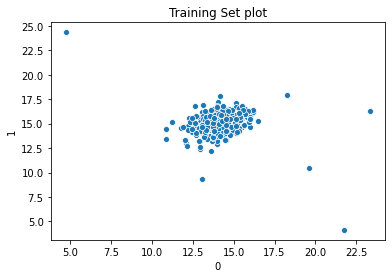

In [28]:
ax = sns.scatterplot(X[0],X[1])
ax.set_title("Training Set plot");

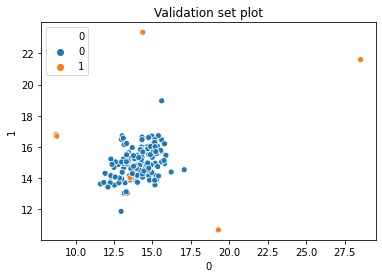

In [29]:
ax = sns.scatterplot(Xval[0],Xval[1],hue=yval[0])
ax.set_title("Validation set plot");

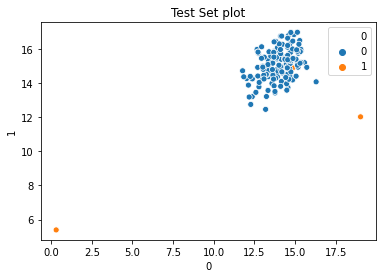

In [30]:
ax = sns.scatterplot(Xval_test[0],Xval_test[1],hue=yval_test[0]);
ax.set_title("Test Set plot");

ใช้ Gaussian Distribution ในการ Predict Anomaly <br><br>
![alt text](https://github.com/BankNatchapol/ML-Algorithm/raw/master/GD.jpg)
ซึ่งสามารถเขียนเป็นสมการได้ว่า<br><br>
\begin{equation}
P(X;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(X-\mu)^2}{2\sigma^2}}
\end{equation}<br>
โดย
\begin{equation}
\mu = \frac{1}{m}\Sigma^m_{i=1}X^{(i)}
\end{equation}<br>
\begin{equation}
\sigma^2 = \frac{1}{m}\Sigma^m_{i=1}(X^{(i)}-\mu)^2
\end{equation}<br><br>
ซึ่งเนื่องจากเป็น Anomaly Detection แบบ Multivariable โดยจากการสังเกตทำให้สามารถประมาณได้ว่า <br><br>
\begin{equation}
P(x;\mu,\sigma^2) = P(x_1;\mu_1,\sigma_1^2)*P(x_2;\mu_2,\sigma_2^2)*P(x_3;\mu_3,\sigma_3^2)*...*P(x;\mu_n,\sigma_n^2)
\end{equation}<br>
หรือ<br><br>
\begin{equation}
P(x;\mu,\sigma^2) = \Pi^n_{j=1}P(x_j;\mu_j,\sigma^2_j)
\end{equation}<br>


In [0]:
class GD:
  def __init__(self):
    self.X = 0
    self.sigma2 = 0
    self.P = 0
    self.u = 0
    self.e = 0.0001

  def fit(self,X):
    m = X.shape[0]
    u = (1/m)*np.array([sum(X[0]),sum(X[1])])
    sigma2 = (1/m)*(X-u)**2
    sigma2 = [sum(sigma2[0]),sum(sigma2[1])]
    P = (1/(np.sqrt(2*np.pi)*np.sqrt(sigma2)))*np.exp(-((X-u)**2)/(list(map(lambda x:x*2,sigma2)))) 
    self.X = X
    self.P = P
    self.u = u
    self.sigma2 = sigma2

  def score(self,X,y):
    m = X.shape[0]
    pred = self.predict(X)
    sc = f1_score(y,pred)
    return sc

  def CVfit(self,Xval,yval,epoch=10000):
    e = 0
    cost = []
    for i in range(epoch//2):
      now = self.score(Xval,yval)
      cost.append(now)
      if now>e:
        e = now
        se = self.e
      self.e += 0.0002
    self.e = se
    return [e,cost]

  def predict(self,X):
    pred = (1/(np.sqrt(2*np.pi)*np.sqrt(self.sigma2)))*np.exp(-((X-self.u)**2)/(list(map(lambda x:x*2,self.sigma2)))) 
    return np.array(list(map(int,pred[0]*pred[1]<self.e)))

ทำการสร้าง Model Anomaly detection

In [0]:
w = GD()

ทำการ Train Model ด้วย Training set

In [0]:
w.fit(X)

ทำ Cross Validation fit เพื่อหาค่า $\epsilon$ ที่เหมาะสมที่สุด

In [0]:
[e,score]=w.CVfit(Xval,yval,10000)

ลอง Plot Gaussian Distribution ผลลัพท์ที่ได้ของทั้ง 2 Features 

2D

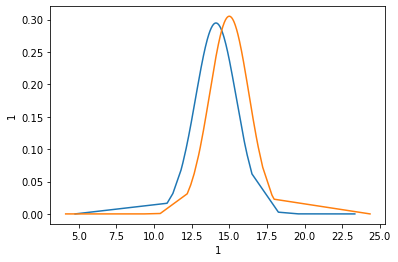

In [0]:
sns.lineplot(X[0],w.P[0])
sns.lineplot(X[1],w.P[1]);

3D เพื่อความ Cool

In [0]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(x=X[0],y=X[1],z=np.dot(np.array([w.P[0]]).T,np.array([w.P[1]])).T)])
fig.update_layout(title='Plot', autosize=False,
                  width=1000, height=1000,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

ดูกราฟ Score เพื่อเปรียบเทียบผลลัพท์

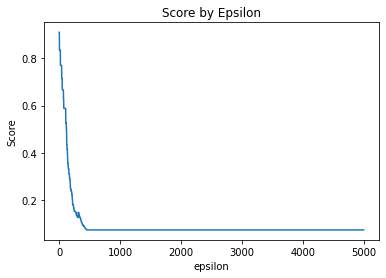

In [33]:
ax = sns.lineplot(np.linspace(0,len(score),len(score)),score);
ax.set_title("Score by Epsilon")
ax.set_ylabel("Score")
ax.set_xlabel("epsilon");

ซึ่งจะได้ผลลัพท์เป็น

In [0]:
print(f'Best Epsilon is {w.e}')

Best Epsilon is 0.0001


In [27]:
print(f'Test score is {w.score(Xval_test,yval_test)}')

Test score is 0.8


เมื่อนำใช้ $\epsilon$ มา Plot เป็น Threshold จะได้ดังภาพ

Training set

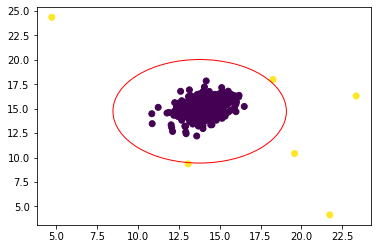

In [41]:
d = (Xval[np.array([w.predict(Xval),1]).T[0]>0] -[np.mean(Xval[0]*np.abs(w.predict(Xval)-1)),np.mean(Xval[1]*np.abs(w.predict(Xval)-1))])

fig, ax = plt.subplots()

c1 = plt.Circle((np.mean(X[0]*np.abs(w.predict(X)-1)), np.mean(X[1]*np.abs(w.predict(X)-1))), np.min(np.sqrt(d[0]**2 +d[1]**2)), color='r',fill=False)
ax.add_artist(c1)
ax.scatter(X[0],X[1],c=w.predict(X));

Validation set

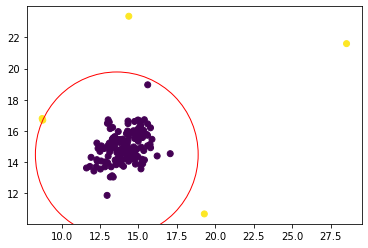

In [42]:
fig, ax = plt.subplots()

c1 = plt.Circle((np.mean(Xval[0]*np.abs(w.predict(Xval)-1)), np.mean(Xval[1]*np.abs(w.predict(Xval)-1))), np.min(np.sqrt(d[0]**2 +d[1]**2)), color='r',fill=False)
ax.add_artist(c1)
ax.scatter(Xval[0],Xval[1],c=w.predict(Xval));

Test set

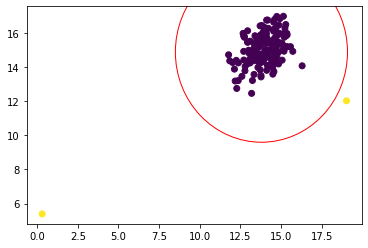

In [43]:
fig, ax = plt.subplots()

c1 = plt.Circle((np.mean(Xval_test[0]*np.abs(w.predict(Xval_test)-1)), np.mean(Xval_test[1]*np.abs(w.predict(Xval_test)-1))), np.min(np.sqrt(d[0]**2 +d[1]**2)), color='r',fill=False)
ax.add_artist(c1)
ax.scatter(Xval_test[0],Xval_test[1],c=w.predict(Xval_test));